# Time series forecasting

## Setup

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv('Dataframes/TBGP_data.csv')
df.pop('DATE')
df.pop('TIME')
df.pop('Hour of Day')
df.pop('Month')
df.pop('Day of Week')
#Salinity same as EC
df.pop('SALINITY')
df.pop('dist_to_sea (km)')
df.pop('DOO (percent saturation) Class')
df.pop('OB_DATE')
df = df.dropna()

#date_time = df['DATE TIME']
date_time = df.pop('DATE TIME')

In [3]:
#transform to datetime64
date_time = pd.to_datetime(date_time, format='%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [4]:
day = 24*60*60 #seconds
year = (365.2425)*day
#returns component of each datetime to range from -0.5 to 0.5
df['Hour of Day'] = date_time.dt.hour/23-0.5
df['Day of Week'] = date_time.dt.dayofweek/6-0.5
df['Month of Year'] = (date_time.dt.month-1)/11-0.5

df['Half Day sin'] = np.sin(timestamp_s * (2 * np.pi / (day/2)))
df['Half Day cos'] = np.cos(timestamp_s * (2 * np.pi / (day/2)))

df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. 

In [5]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [6]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

### 1. Indexes and offsets

In [7]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

### 2. Split

In [8]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

### 3. Plot

In [9]:
#'DOO-MGL'
def plot(self, model=None, plot_col='DOO-MGL', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [15-min]')

WindowGenerator.plot = plot

### 4. Create `tf.data.Dataset`s

In [10]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [11]:
#The `WindowGenerator` object holds training, validation, and test data.
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [12]:
MAX_EPOCHS = 20
#Package the training procedure into a function:
def compile_and_fit(model, window, patience=3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights=True)

  model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

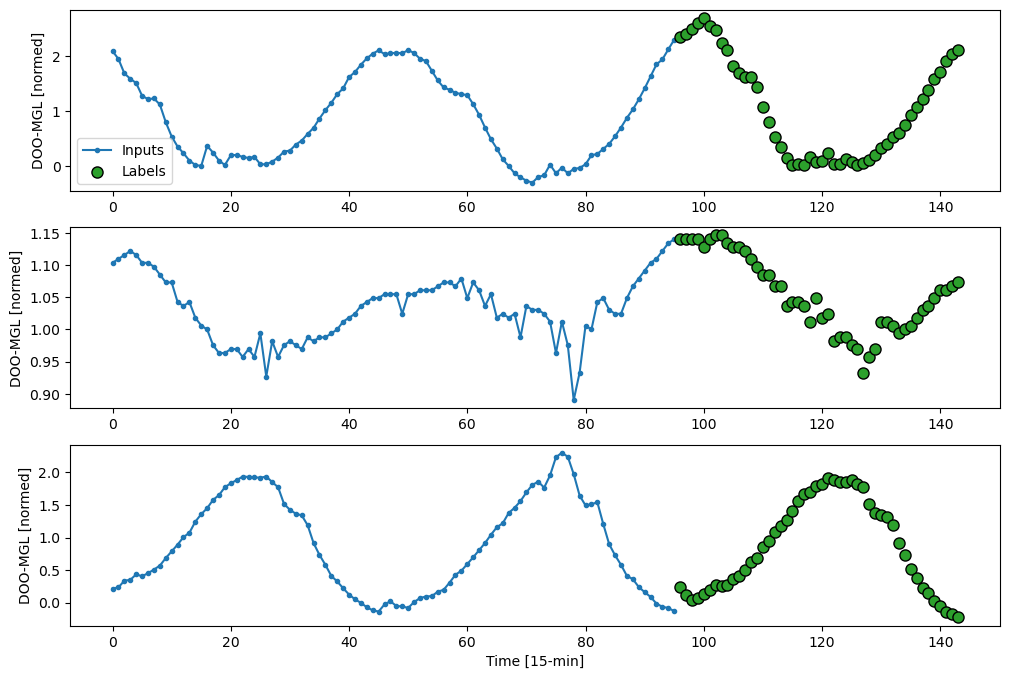

In [13]:
#Manually enter the input and output lengths here:
OUT_STEPS = 48
multi_window = WindowGenerator(input_width=96,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['DOO-MGL'])

multi_window.plot()

### Baselines

732/732 [==============================] - 1s 521us/step - loss: 0.2384 - mean_absolute_percentage_error: 72.2888


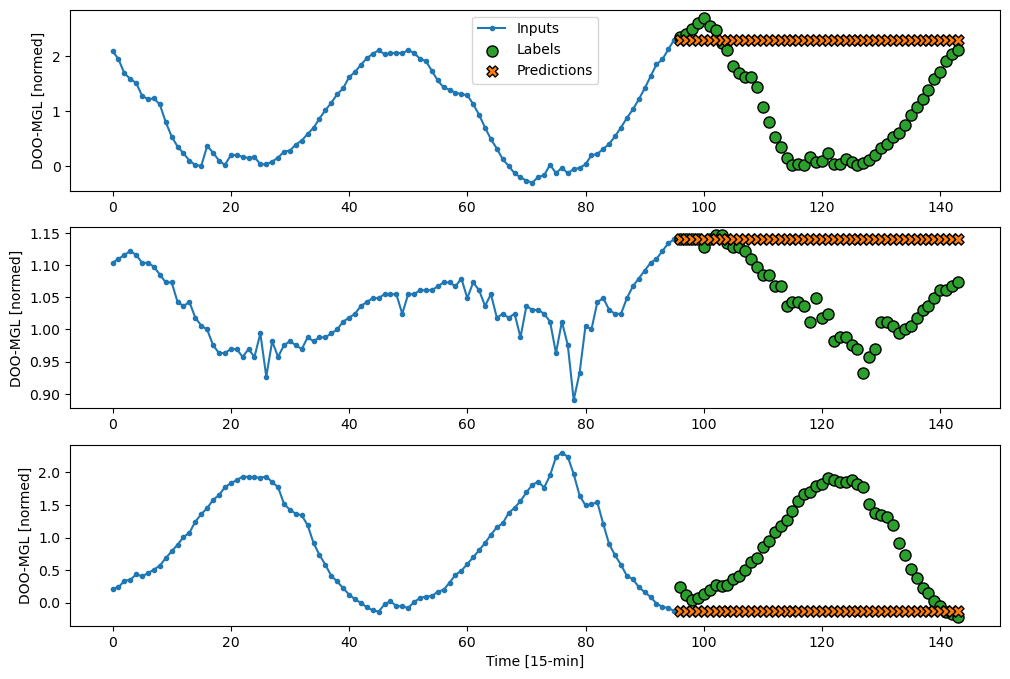

In [14]:
class MultiStepLastBaseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index    
    
  def call(self, inputs): 
    if self.label_index is None:
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])
    return tf.tile(inputs[:, -1, self.label_index][:,None, None], [1, OUT_STEPS,1])

last_baseline = MultiStepLastBaseline(label_index=column_indices['DOO-MGL'])
last_baseline.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                      optimizer=tf.keras.optimizers.Adam(0.0001),
                      metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

732/732 [==============================] - 0s 514us/step - loss: 0.1514 - mean_absolute_percentage_error: 50.3681


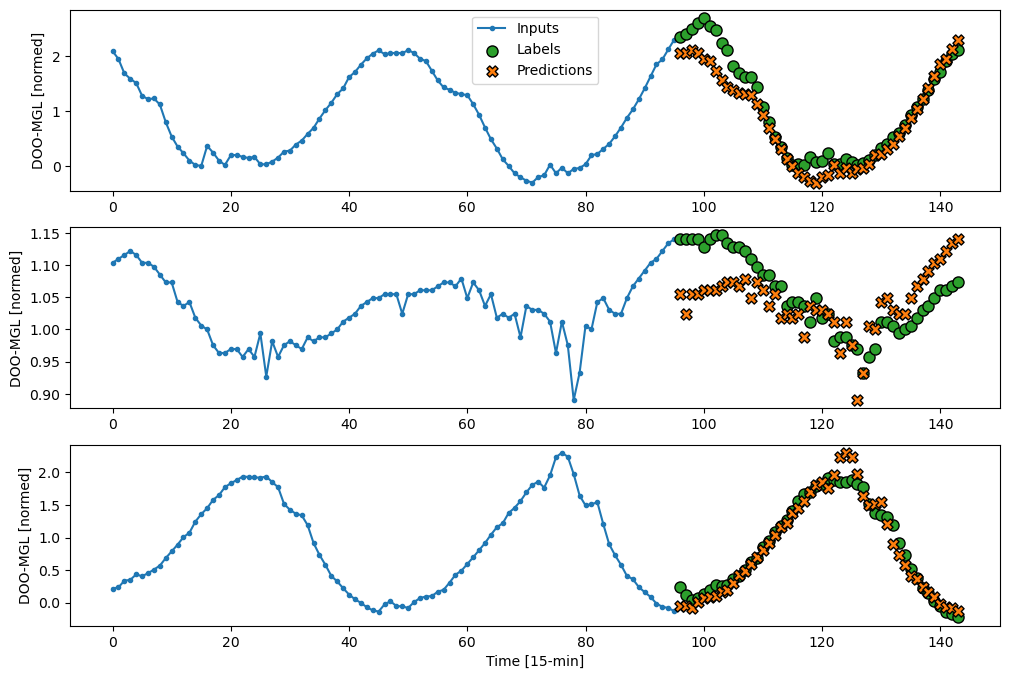

In [16]:
class RepeatBaseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index    
    
  def call(self, inputs): 
    if self.label_index is None:
        return inputs
    return inputs[:, 48:96, self.label_index][:, :, tf.newaxis]

repeat_baseline = RepeatBaseline(label_index=column_indices['DOO-MGL'])
repeat_baseline.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                        optimizer=tf.keras.optimizers.Adam(0.0001),
                        metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

#### Linear


732/732 [==============================] - 0s 533us/step - loss: 0.2717 - mean_absolute_percentage_error: 108.7265


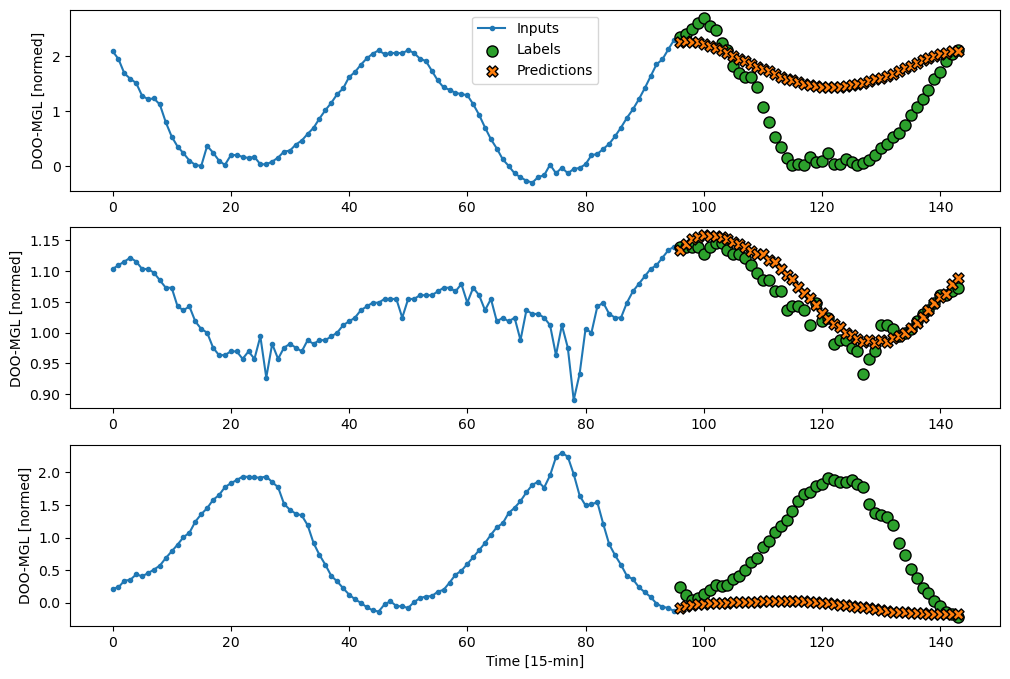

In [17]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense


732/732 [==============================] - 1s 659us/step - loss: 0.3052 - mean_absolute_percentage_error: 117.4430


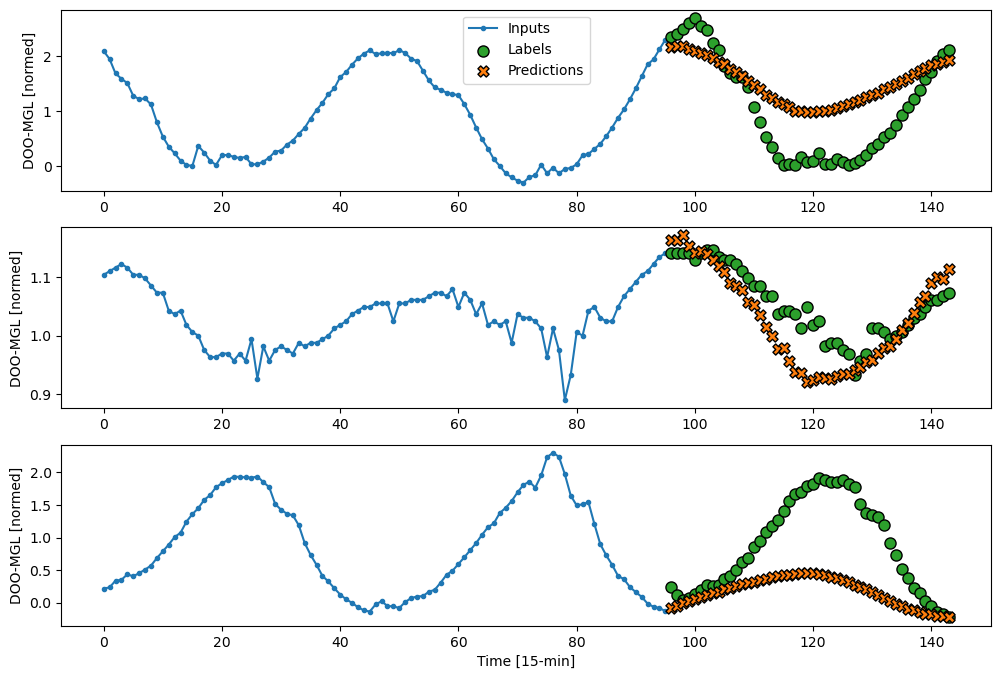

In [18]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

732/732 [==============================] - 0s 591us/step - loss: 0.3132 - mean_absolute_percentage_error: 121.2303


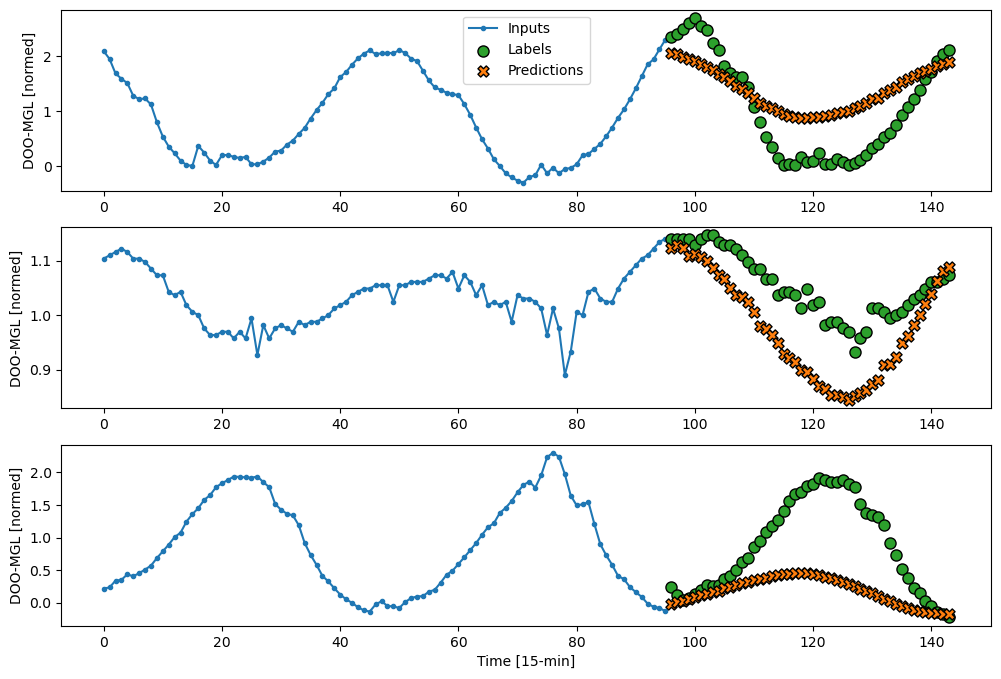

In [19]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

732/732 [==============================] - 3s 5ms/step - loss: 0.3964 - mean_absolute_percentage_error: 117.5943


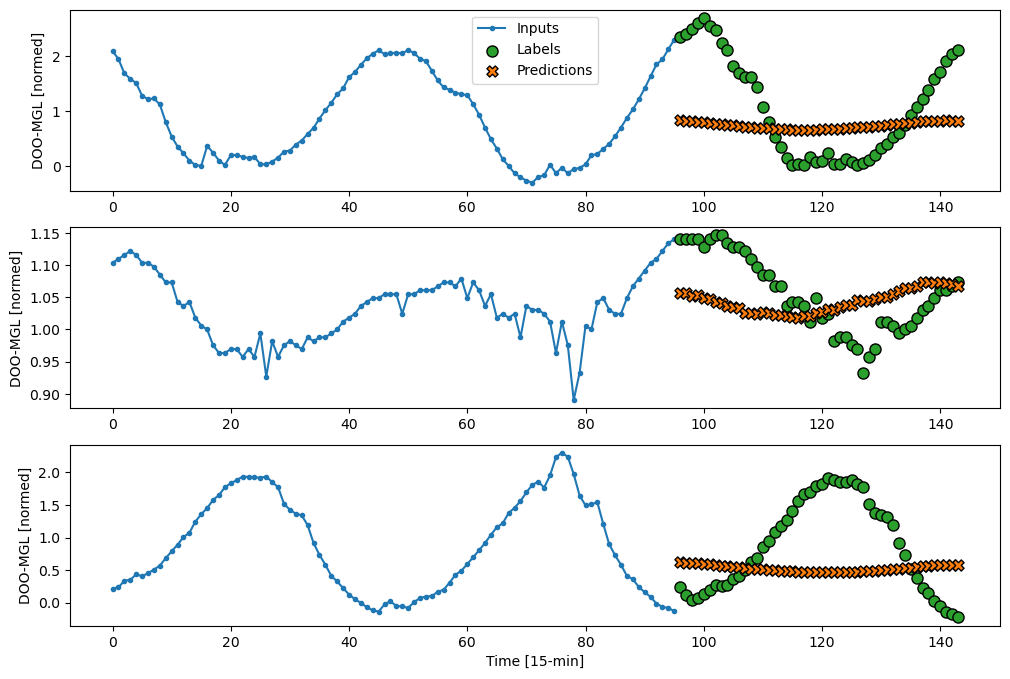

In [20]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Performance

In [22]:
#after each run, append the result
for name, value in multi_performance.items():
    multi_performance_runs[name].append(value[1])  # Accumulate the values

In [73]:
# After running 10 times, calculate the average for each model
for name, values in multi_performance_runs.items():
    average = sum(values) / len(values)
    print(f'{name:8s}: {average:0.4f}')

Last    : 0.2531
Repeat  : 0.1778
Linear  : 0.3290
Dense   : 0.3217
Conv    : 0.3243
LSTM    : 0.2369
